# Fair Value Estimator

### About

I wrote this notebook so that my friends and I can save time when estimating the fair value of a stock. All information about the stock is pulled from [Morningstar](https://www.morningstar.com/). Note that this is just how I estimate the fair value, and that my methods, just like all methods, are imperfect. The fair value will never be exactly equal to what I estimate it to be at, but on average I expect to be close enough. As a long-term investor, I'm confident that if I continually buy strong stocks at prices significantly below fair value, I will make alot of money in the long run.

Here are some things to keep in mind: 
* The following modules need to be installed on your computer: Ipython, numpy, pandas, matplotlib, seaborn, selenium
* This method of valuation only works for established companies with positive earnings. Investing in a new company with no history or negative earnings is speculative in nature, which makes it hard to determine a "fair value" for its stock.
* The user needs to input 3 values: the ticker symbol of the stock being valued, the acceptable annual returns (%), the expected future growth (%), and the PE ratio that the stock will be sold at.
* Buying a stock when it's cheap is only one part of the equation. The stock needs to have a "moat", and ideally a good balance sheet, and you need to understand the business (so you know when to sell). If any of these need clarification, please see the link below.
* I have details behind how I estimate fair value, as well as notes/tips on investing in my [Github repository](https://github.com/zihanye96/Fair-Value-Estimator).


In [1]:
## required libraries
import IPython
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## for web scraping
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait as wait

In [2]:
ticker = "COST"

In [3]:
import datetime
present_year = datetime.datetime.now().year

In [4]:
rownames = list(np.arange(present_year-10,present_year+1))

In [5]:
stock_data = pd.DataFrame({"Year":rownames})

In [6]:
def fetchPriceRatios(ticker):
    
    driver = webdriver.Chrome(executable_path='./chromedriver')
    driver.get(f'http://financials.morningstar.com/valuation/price-ratio.html?t={ticker}&region=usa&culture=en-US')

    tbody = wait(driver, 10).until(EC.presence_of_element_located((By.ID, "valuation_history_table")))

    rows = tbody.find_elements_by_tag_name("tr")

    row_content = [row.text for row in rows]
    stock_data["PE Ratio"] = row_content[1].split(" ")[1:]
    stock_data["Price to Book"] = row_content[4].split(" ")[1:]
    stock_data["Price to Sales"] = row_content[7].split(" ")[1:]

    driver.close()

In [7]:
def fetchFinancials(ticker):
    
    driver = webdriver.Chrome(executable_path='./chromedriver')
    driver.get(f'http://financials.morningstar.com/ratios/r.html?t={ticker}&region=usa&culture=en-US')
    
    tbody = wait(driver, 10).until(EC.presence_of_element_located((By.ID, "financials")))
    rows = tbody.find_elements_by_tag_name("tr")
    row_content = [row.text for row in rows]
    
    currency = row_content[2].split(" ")[1]
    stock_data["Revenue"] = row_content[2].split(" ")[3:]
    stock_data["Net Income"] = row_content[10].split(" ")[4:]
    stock_data[f"EPS ({currency})"] = row_content[12].split(" ")[4:]
    stock_data["BVPS"] = row_content[20].split(" ")[6:]
    
    tbody = wait(driver, 10).until(EC.presence_of_element_located((By.ID, "tab-profitability")))
    rows = tbody.find_elements_by_tag_name("tr")
    row_content = [row.text for row in rows]
    
    stock_data["ROE"] = row_content[32].split(" ")[4:]
    stock_data["ROIC"] = row_content[34].split(" ")[5:]
    
    driver.close()

In [8]:
fetchPriceRatios(ticker)
fetchFinancials(ticker)

In [9]:
type(stock_data[["BVPS"]])

pandas.core.frame.DataFrame

In [10]:
stock_data.loc[1, "BVPS"]

'27.64'

In [11]:
type(stock_data["Revenue"][0])

str

In [12]:
def to_num(column):
    if type(column[0]) == str:
        return(column.str.replace(',', '').str.replace('—', '0').astype(float))
    else:
        return(column)

In [13]:
stock_data.apply(to_num, axis=0)

,Year,PE Ratio,Price to Book,Price to Sales,Revenue,Net Income,EPS (USD),BVPS,ROE,ROIC
0,2010,23.8,2.8,0.4,77946.0,1303.0,2.92,24.98,12.50,10.74
1,2011,25.1,3.0,0.4,88915.0,1462.0,3.30,27.64,12.81,11.13
2,2012,24.0,3.4,0.4,99137.0,1709.0,3.89,28.59,14.03,12.46
3,2013,25.6,4.7,0.5,105156.0,2039.0,4.63,23.98,17.58,14.04
4,2014,29.5,5.1,0.5,112640.0,2058.0,4.65,27.00,17.79,12.63
5,2015,30.2,6.5,0.6,116199.0,2377.0,5.37,24.17,20.74,13.69
6,2016,29.2,5.9,0.6,118719.0,2350.0,5.33,26.30,20.71,14.18
7,2017,29.6,7.4,0.6,129025.0,2679.0,6.08,22.57,23.44,15.78
8,2018,27.6,6.8,0.6,141576.0,3134.0,7.09,27.69,26.59,17.44
9,2019,34.8,8.2,0.8,152703.0,3659.0,8.26,32.94,26.10,17.09


In [14]:
stock_data = stock_data.apply(to_num, axis=0)

In [15]:
revenue_percent_change = stock_data.iloc[:, 4].pct_change()
Income_percent_change = stock_data.iloc[:, 5].pct_change()
EPS_percent_change = stock_data.iloc[:, 6].pct_change()
BVPS_percent_change = stock_data.iloc[:, 7].pct_change()
percent_change = pd.DataFrame({"Revenue": revenue_percent_change, "Income": Income_percent_change,
                              "Book Value": BVPS_percent_change, "EPS": EPS_percent_change})

In [16]:
stock_data

,Year,PE Ratio,Price to Book,Price to Sales,Revenue,Net Income,EPS (USD),BVPS,ROE,ROIC
0,2010,23.8,2.8,0.4,77946.0,1303.0,2.92,24.98,12.50,10.74
1,2011,25.1,3.0,0.4,88915.0,1462.0,3.30,27.64,12.81,11.13
2,2012,24.0,3.4,0.4,99137.0,1709.0,3.89,28.59,14.03,12.46
3,2013,25.6,4.7,0.5,105156.0,2039.0,4.63,23.98,17.58,14.04
4,2014,29.5,5.1,0.5,112640.0,2058.0,4.65,27.00,17.79,12.63
5,2015,30.2,6.5,0.6,116199.0,2377.0,5.37,24.17,20.74,13.69
6,2016,29.2,5.9,0.6,118719.0,2350.0,5.33,26.30,20.71,14.18
7,2017,29.6,7.4,0.6,129025.0,2679.0,6.08,22.57,23.44,15.78
8,2018,27.6,6.8,0.6,141576.0,3134.0,7.09,27.69,26.59,17.44
9,2019,34.8,8.2,0.8,152703.0,3659.0,8.26,32.94,26.10,17.09


### Summary

PE Ratio over last 10 years: [23.8 25.1 24.  25.6 29.5 30.2 29.2 29.6 27.6 34.8 37.3]


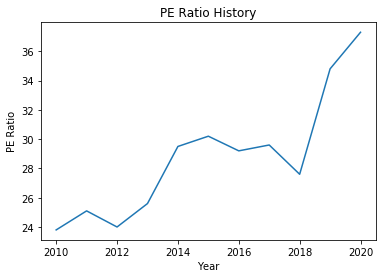

In [17]:
sns.lineplot(stock_data["Year"],stock_data["PE Ratio"])
plt.title("PE Ratio History")
print("PE Ratio over last 10 years: {}".format(np.array(stock_data["PE Ratio"])))

In [18]:
PE_sell = input("Based on historical data, what PE Ratio will you sell at?")

Based on historical data, what PE Ratio will you sell at?40


In [19]:
## format the df's better - use green for above 15%, red for negative?

print("Management Effectiveness: \n{}".format(pd.DataFrame({"ROIC": stock_data["ROIC"], 
                                                            "ROE": stock_data["ROE"]})))
print("% Growth in: \n{}".format(percent_change.iloc[1:10,:]*100))

Management Effectiveness: 
     ROIC    ROE
0   10.74  12.50
1   11.13  12.81
2   12.46  14.03
3   14.04  17.58
4   12.63  17.79
5   13.69  20.74
6   14.18  20.71
7   15.78  23.44
8   17.44  26.59
9   17.09  26.10
10  16.85  24.80
% Growth in: 
     Revenue     Income  Book Value        EPS
1  14.072563  12.202609   10.648519  13.013699
2  11.496373  16.894665    3.437048  17.878788
3   6.071396  19.309538  -16.124519  19.023136
4   7.117045   0.931829   12.593828   0.431965
5   3.159624  15.500486  -10.481481  15.483871
6   2.168693  -1.135886    8.812578  -0.744879
7   8.681003  14.000000  -14.182510  14.071295
8   9.727572  16.983949   22.684980  16.611842
9   7.859383  16.751755   18.959913  16.502116


In [20]:
future_growth = input("Based on historical data, how much (in %) do you think the EPS will grow on average over the next 5 years?")
annual_ror = input("What is the per year rate of return (in %) do you want from this investment?")

Based on historical data, how much (in %) do you think the EPS will grow on average over the next 5 years?10
What is the per year rate of return (in %) do you want from this investment?10


In [21]:
def estimate_fair_value(EPS, future_growth, ror, PE):
    
    future_value = EPS * (1+future_growth/100)**5 * PE
    present_value = future_value/((1+ror/100)**5)
    return(future_value, present_value)

In [22]:
future, present = estimate_fair_value(stock_data.iloc[10, 6], float(future_growth), float(annual_ror), float(PE_sell))

print("Fair Value Estimate: ${:.2f}".format(present))
print("The future value of your investment is: ${:.2f}".format(future))

Fair Value Estimate: $340.80
The future value of your investment is: $548.86
